In [2]:
import cv2
import os
import imutils
import numpy as np
import dlib
from pathlib import Path
from imutils import face_utils
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
import math

In [3]:
from facemaskmaker import FaceMaskMaker

dataset_masks_path = os.path.abspath('../datasets/ds2_face_recognition_dataset/lfw_funneled')
image_paths = list(Path(dataset_masks_path).rglob("*.jpg"))

print(f'Images: {len(image_paths)}')

Images: 13233


In [4]:
def print_image(img, title = 'result'):
    copy_img = img.copy()
    copy_img = cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB)
    plt.imshow(copy_img)
    plt.title(title)
    plt.show()

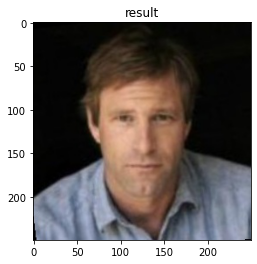

In [5]:
image0 = cv2.imread(str(image_paths[0]))
print_image(image0)

In [6]:
def getFaceRectanglesByCnnDlib(image):
    detector = dlib.cnn_face_detection_model_v1('../models/mmod_human_face_detector.dat')
    m_rectangles = detector(image, 1)
    # for (i, m_rect) in enumerate(m_rectangles):
        # (rectangleX, rectangleY, rectangleWidth, rectangleHeight) = face_utils.rect_to_bb(m_rect.rect)
        # cv2.rectangle(image, (rectangleX, rectangleY), (rectangleX + rectangleWidth, rectangleY + rectangleHeight), (0, 255, 0), 2)
        # cv2.putText(image, f"Face #{i+1}", (rectangleX, rectangleY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # print_image(image)

    return [m_rect.rect for m_rect in m_rectangles]

# c_image = image0.copy()
# rectangles = getFaceRectanglesByCnnDlib(c_image)
# print(rectangles)

In [7]:
def getShape68ByDlib(image, rectangles):
    shape_predictor = dlib.shape_predictor('../models/shape_predictor_68_face_landmarks.dat')
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    shapes = []
    for (i, rect) in enumerate(rectangles):
        shape = shape_predictor(grayImage, rect)
        shape = face_utils.shape_to_np(shape)
        shapes.append(shape)

        # shape points
        # for i in range(len(shape)):
        #     x, y = shape[i]
        #     cv2.circle(image, (x, y), 2, (0, 0, 255), -1)

    # print_image(image)

    return shapes

# c_image = image0.copy()
# shapes = getShape68ByDlib(c_image, rectangles)
# print(f'Shapes: {len(shapes)}')

In [8]:
def overlayImage(bg_image, fg_image, x_coord, y_coord):
    result_image = bg_image.copy()
    y1, y2 = y_coord, y_coord + fg_image.shape[0]
    x1, x2 = x_coord, x_coord + fg_image.shape[1]
    fg_alpha = fg_image[:, :, 3] / 255.0
    bg_alpha = 1.0 - fg_alpha
    for c in range(0, 3):
        result_image[y1:y2, x1:x2, c] = (fg_alpha * fg_image[:, :, c] + bg_alpha * bg_image[y1:y2, x1:x2, c])

    return result_image

In [9]:
def calculateFaceAngel(shape):
    x, y = shape[8]
    a = np.asarray((x, y-1))
    b = np.asarray(shape[8])
    c = np.asarray(shape[27])
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return math.degrees(angle)

In [10]:
def addFaceMask(face_image, mask_image, shapes):
    for shape in shapes:
        left_x, left_y = shape[1]
        right_x, right_y = shape[15]
        topX, top_y = shape[28]
        bottomX, bottom_y = shape[8]

        face_angel = calculateFaceAngel(shape)
        isLeftSide = shape[27][0] < shape[8][0]
        if isLeftSide:
            face_angel *= -1

        mask_new_width, mask_new_height = right_x - left_x, bottom_y - top_y
        resized_mask_img = cv2.resize(mask_image, (mask_new_width, mask_new_height), interpolation=cv2.INTER_CUBIC)
        rotated_mask_img = imutils.rotate_bound(resized_mask_img, face_angel)

        mask_x, mask_y = (right_x - mask_new_width, right_y) if isLeftSide else (left_x - np.abs(rotated_mask_img.shape[1] - resized_mask_img.shape[1]), left_y)

        face_image = overlayImage(face_image, rotated_mask_img, mask_x, mask_y)

    return face_image

In [12]:
face_image = cv2.imread('../imgs/angels/3.jpg')
mask_image = cv2.imread('../datasets/mask_images/mask_3.png', cv2.IMREAD_UNCHANGED)
rectangles = getFaceRectanglesByCnnDlib(face_image)
shapes = getShape68ByDlib(face_image, rectangles)
face_image_with_mask = addFaceMask(face_image, mask_image, shapes)

print_image(face_image_with_mask)

TypeError: __call__(): incompatible function arguments. The following argument types are supported:
    1. (self: _dlib_pybind11.cnn_face_detection_model_v1, imgs: list, upsample_num_times: int=0, batch_size: int=128) -> std::vector<std::vector<dlib::mmod_rect,std::allocator<dlib::mmod_rect> >,std::allocator<std::vector<dlib::mmod_rect,std::allocator<dlib::mmod_rect> > > >
    2. (self: _dlib_pybind11.cnn_face_detection_model_v1, img: array, upsample_num_times: int=0) -> std::vector<dlib::mmod_rect,std::allocator<dlib::mmod_rect> >

Invoked with: <_dlib_pybind11.cnn_face_detection_model_v1 object at 0x000001C7838125B0>, None, 1

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

In [13]:
face_image = cv2.imread('../imgs/angels/3.jpg')
mask_image = cv2.imread('../datasets/mask_images/mask_1.png', cv2.IMREAD_UNCHANGED)
args = {}
face_mask_maker = FaceMaskMaker(args)
result_image = face_mask_maker.add_face_mask(face_image, mask_image)
print_image(result_image)

TypeError: __call__(): incompatible function arguments. The following argument types are supported:
    1. (self: _dlib_pybind11.cnn_face_detection_model_v1, imgs: list, upsample_num_times: int=0, batch_size: int=128) -> std::vector<std::vector<dlib::mmod_rect,std::allocator<dlib::mmod_rect> >,std::allocator<std::vector<dlib::mmod_rect,std::allocator<dlib::mmod_rect> > > >
    2. (self: _dlib_pybind11.cnn_face_detection_model_v1, img: array, upsample_num_times: int=0) -> std::vector<dlib::mmod_rect,std::allocator<dlib::mmod_rect> >

Invoked with: <_dlib_pybind11.cnn_face_detection_model_v1 object at 0x000001C78487A130>, None, 1

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

In [14]:
def get_paths_of_files_by_extension(path, extension='png'):
    return [str(path) for path in list(Path(os.path.abspath(path)).rglob(f"*.{extension}"))]

Image 1, mask 1:


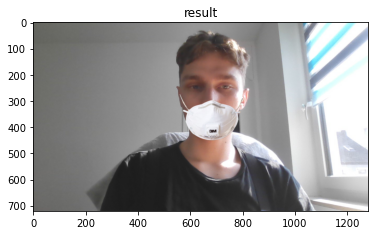

Image 1, mask 2:


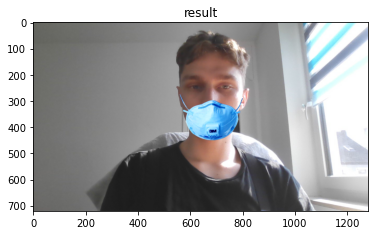

Image 1, mask 3:


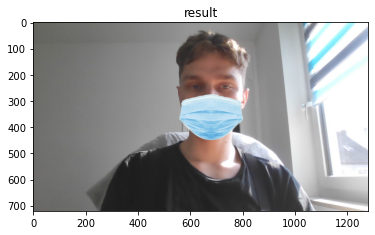

Image 1, mask 4:


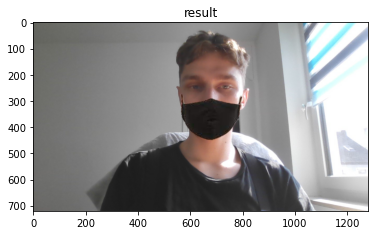

Image 1, mask 5:


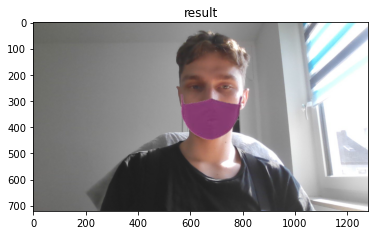

Image 1, mask 6:


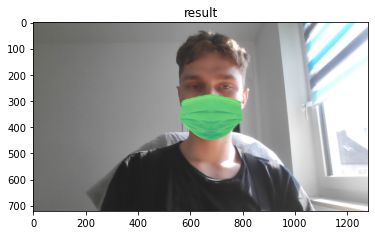

Image 1, mask 7:


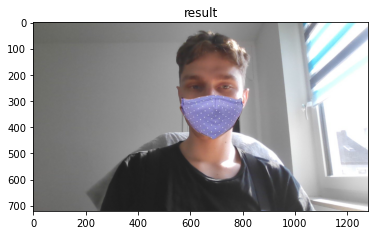

Image 1, mask 8:


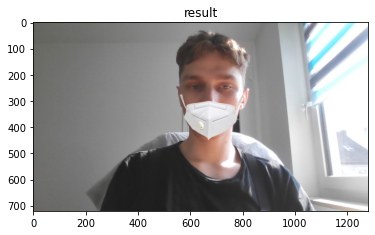

Image 1, mask 9:


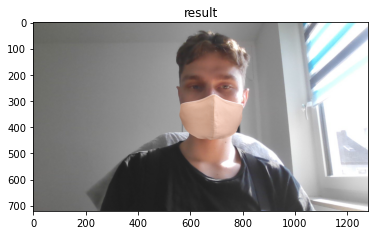

Image 2, mask 1:


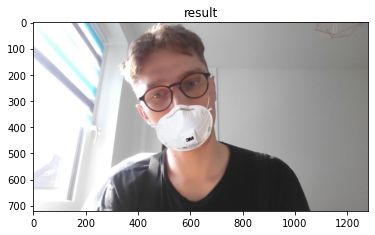

Image 2, mask 2:


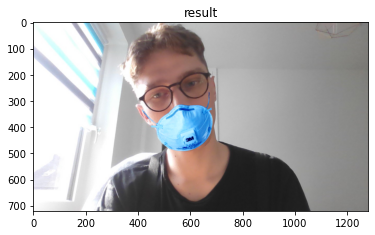

Image 2, mask 3:


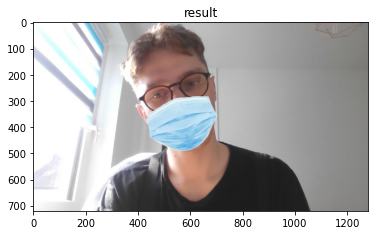

Image 2, mask 4:


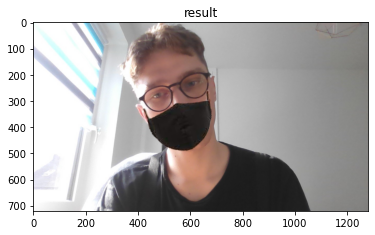

Image 2, mask 5:


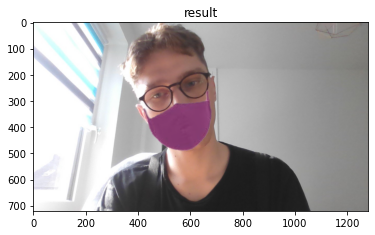

Image 2, mask 6:


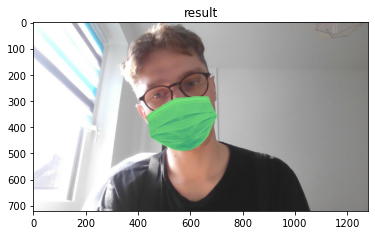

Image 2, mask 7:


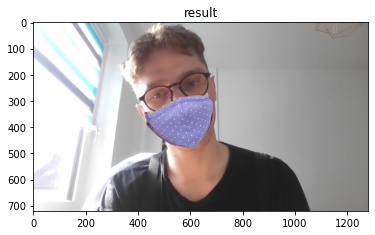

Image 2, mask 8:


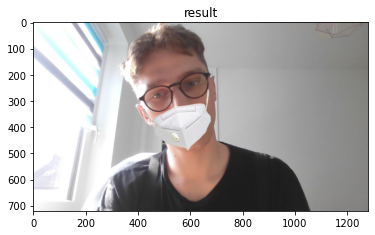

Image 2, mask 9:


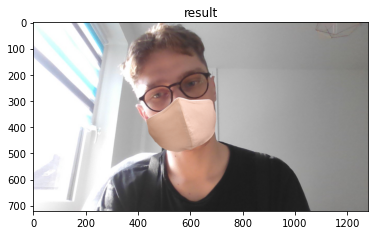

Image 3, mask 1:


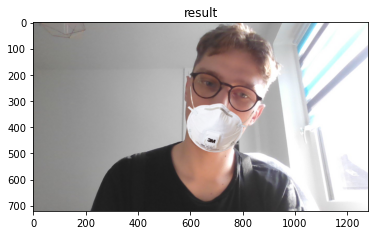

Image 3, mask 2:


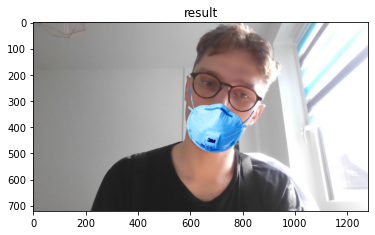

Image 3, mask 3:


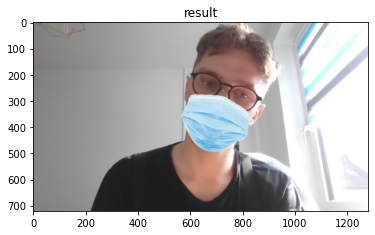

Image 3, mask 4:


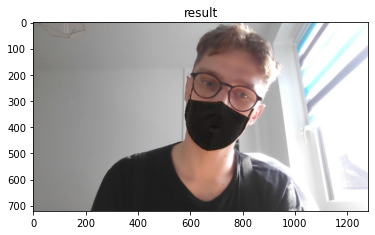

Image 3, mask 5:


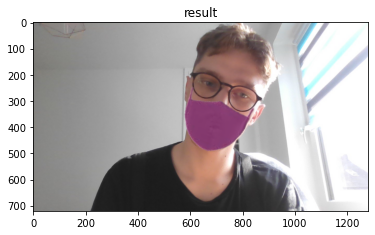

Image 3, mask 6:


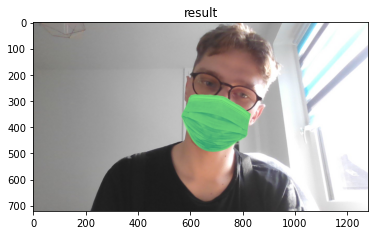

Image 3, mask 7:


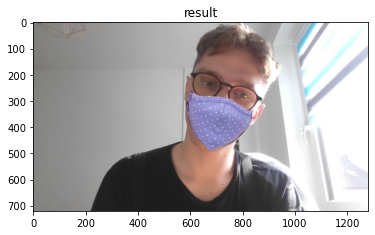

Image 3, mask 8:


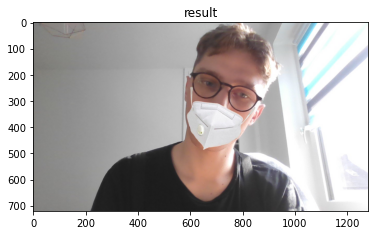

Image 3, mask 9:


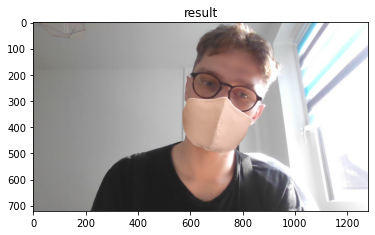

In [18]:
mask_image_paths = get_paths_of_files_by_extension('../datasets/mask_images')
face_image_paths = get_paths_of_files_by_extension('../datasets/ds4_angels', 'jpg')
for (i, face_image_path) in enumerate(face_image_paths):
    face_image = cv2.imread(face_image_path)
    for (j, mask_image_path) in enumerate(mask_image_paths):
        mask_image = cv2.imread(mask_image_path, cv2.IMREAD_UNCHANGED)
        print(f'Image {i+1}, mask {j+1}:')
        image_result = face_mask_maker.add_face_mask(face_image, mask_image)
        print_image(image_result)

In [ ]:
# generate fake dataset
mask_image_paths = get_paths_of_files_by_extension('../datasets/mask_images')
face_image_paths = get_paths_of_files_by_extension('../datasets/ds2_face_recognition_dataset/lfw_funneled', 'jpg')

